In [1]:
import importlib
import moment_kernels as mk
importlib.reload(mk)
import torch
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor,RandomRotation
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
from sklearn.metrics import accuracy_score,roc_auc_score
import medmnist
from torchvision.datasets import MNIST

In [2]:
device = 'cuda:0'

In [3]:
dataset = CIFAR10('/home/dtward/data',transform=ToTensor())
dataset_test = CIFAR10('/home/dtward/data',transform=ToTensor(),train=False)

In [4]:
dataset = medmnist.BloodMNIST(transform=ToTensor(),split='train')
dataset_test = medmnist.BloodMNIST(transform=ToTensor(),split='test')

In [5]:
dataset = medmnist.DermaMNIST(transform=ToTensor(),split='train')
dataset_test = medmnist.DermaMNIST(transform=ToTensor(),split='test')

In [6]:
dataset = MNIST('/home/dtward/data',transform=ToTensor(),train=True)
dataset_test = MNIST('/home/dtward/data',transform=ToTensor(),train=False)

In [7]:
labels = []
for x,l in dataset_test:
    labels.append(l)
labels = np.unique(labels)
nlabels = len(labels)
print(nlabels)

10


In [8]:
loader = torch.utils.data.DataLoader(dataset,batch_size=128,shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test,batch_size=128)

<IPython.core.display.Javascript object>


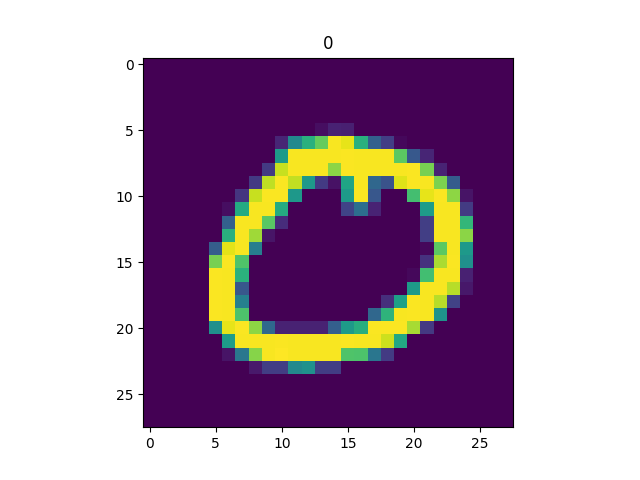

Text(0.5, 1.0, '0')

In [9]:
for x,l in loader:
    break
fig,ax = plt.subplots()
ax.imshow(x[0].permute(1,2,0))
ax.set_title(f'{l[0]}')

In [10]:
class Net(torch.nn.Module):
    def __init__(self,out_channels):
        super().__init__()
        
        channels0 = 8
        kernel_size = 5
        padding = (kernel_size-1)//2
        
        # build a convolution layer
        # that takes 3 scalar images and 0 vector images as input (3 channels total)
        # and it will output 8 scalar images, and 8 vector images (8+8*2=24 channels total)
        # convention: at every layer, we will use the same number of scalar and vector channels
        # to map from a scalar to a scalar it uses a kernel of the form f(|x|)
        # to map from scalar to vector it uses a kernel of the form f(|x|)x
        # to map from vector to scalar it uses a kernel of the form f(|x|)x^T
        # to map from vector to vector it uses a kernel of the form f_1(|x|)id + f_2(|x|)xx^T
        # in this example, we will use 8x3 kernels of the form f(|x|) 
        # each scalar channel in the input is coupled to each scalar channel in the output with one convolution
        # and we will use 8x3 kernels of the form f(|x|)x
        # each scalar channel in the input is coupled to each vector channel in the output with one convolution
        
        # for a more specific example, let's say there were 3 input scalars, and 2 output scalars and 2 output vectors
        #
        # say I_i(x) is the ith of 3 scalar channels in the input image (i=1 means red, 2 means green 3 means blue)
        # and Js_j(x) is the jth of 2 scalar channels in the output image
        # and Jv_j(x) is the jth of 2 vector channels in the output image
        # the equation is, kernels are f_ij
        # Js_1(x) = int f_11(|x-x'|)I_1(x') dx' + int f_12(|x-x'|)I_2(x')dx' + int f_13(|x-x'|)I_3(x')dx'
        # Js_2(x) = int f_21(|x-x'|)I_1(x') dx' + int f_22(|x-x'|)I_2(x')dx' + int f_23(|x-x'|)I_3(x')dx'        
        # for the vector part, kernels are g_ij
        # Jv_1(x) = int g_11(|x-x'|)(x-x')I_1(x')dx' 
        #         + int g_12(|x-x'|)(x-x')I_2(x')dx' 
        #         + int g_13(|x-x'|)(x-x')I_3(x')dx'
        # note that Jv_1 has two components (x and y)
        # Jv_2(x) = int g_21(|x-x'|)(x-x')I_1(x')dx' 
        #         + int g_22(|x-x'|)(x-x')I_2(x')dx' 
        #         + int g_23(|x-x'|)(x-x')I_3(x')dx'
        # note Jv_2 also has two components
        # the last thing the layer does is stack them on top of each other
        # so J = [Js,Jv] # stacked on top
        # so theres a total of 24 channels (8 scalars, 8 vector x components, and 8 vector y components)
        # 
        # how would you do the same thing in ecnn framework
        # input_field_type = [trial]*3
        # output_field_type = [trivial]*2 + [irreducible]*2
        # I think this would be equivalent
        self.c0 = mk.ScalarVectorToScalarVector(in_scalars=x.shape[1],in_vectors=0,out_scalars=channels0,out_vectors=channels0, kernel_size=kernel_size, padding=padding)
        self.b0 = mk.ScalarVectorBatchnorm(channels0,channels0)
        self.s0 = mk.ScalarVectorSigmoid(channels0)
        
        self.c1 = mk.ScalarVectorToScalarVector(in_scalars=channels0,in_vectors=channels0,out_scalars=channels0*2,out_vectors=channels0*2,kernel_size=kernel_size,padding=padding)
        # why downsample instead of strided convolution?
        # if the image has an even number of pixels, a strided convolution will start with the first and skip the last
        # if it was size 4
        # o o o o
        # and to downsample it would pick these pixels with an x, every other pixel
        # x o x o
        # this operation is not rotation invariant, because if you flipped the image it would pick the last pixel instead of the first
        # so if the size is even, we will average neighbors
        # mean( o o) mean( o o)
        # and this operation is rotationally invariant, no pixels get skipped and the left side looks like the right
        # if the size is odd, e.g. 5
        # o o o o o
        # we can take every other pixel
        # x o x o x
        # and it will be the same if I rotate or reflect
        # this layer checks if the size is even or odd, if it is even it does averaging, odd it does skipping
        self.d1 = mk.Downsample()
        # batchnorm is regular for scalars
        # and for vectors it applies a batchnorm to the log of their magnitude
        self.b1 = mk.ScalarVectorBatchnorm(channels0*2,channels0*2)
        # for sigmoid, it is a relu for scalars
        # and for vectors it maps their magnitude to |x| \mapsto relu( |x| - 1)
        # the function looks kind of like \__/, kind of like a relu, but symmetric
        self.s1 = mk.ScalarVectorSigmoid(channels0*2)
        
        self.c2 = mk.ScalarVectorToScalarVector(in_scalars=channels0*2,in_vectors=channels0*2,out_scalars=channels0*4,out_vectors=channels0*4,kernel_size=kernel_size,padding=padding)
        self.d2 = mk.Downsample()
        self.b2 = mk.ScalarVectorBatchnorm(channels0*4,channels0*4)
        self.s2 = mk.ScalarVectorSigmoid(channels0*4)
        
        self.c3 = mk.ScalarVectorToScalarVector(in_scalars=channels0*4,in_vectors=channels0*4,out_scalars=channels0*8,out_vectors=channels0*8,kernel_size=kernel_size,padding=padding)
        self.d3 = mk.Downsample()
        self.b3 = mk.ScalarVectorBatchnorm(channels0*8,channels0*8)
        self.s3 = mk.ScalarVectorSigmoid(channels0*8)
        
        self.c4 = mk.ScalarVectorToScalarVector(in_scalars=channels0*8,in_vectors=channels0*8,out_scalars=channels0*16,out_vectors=channels0*16,kernel_size=kernel_size,padding=padding)
        self.d4 = mk.Downsample()
        self.b4 = mk.ScalarVectorBatchnorm(channels0*16,channels0*16)
        self.s4 = mk.ScalarVectorSigmoid(channels0*16)
        
        # last time we will map to only scalars, and no vectors
        # we need to map to 10 scalars for the 10 class probability in cifar
        self.c5 = mk.ScalarVectorToScalarVector(in_scalars=channels0*16,in_vectors=channels0*16,out_scalars=out_channels,out_vectors=0,kernel_size=kernel_size,padding=padding)
        self.d5 = mk.Downsample()
        
        
        
        
        
    def forward(self,x):
        x = self.c0(x)
        x = self.b0(x)
        x = self.s0(x)
        
        x = self.c1(x)
        x = self.d1(x)
        x = self.b1(x)
        x = self.s1(x)
        
        x = self.c2(x)
        x = self.d2(x)
        x = self.b2(x)
        x = self.s2(x)
        
        x = self.c3(x)
        x = self.d3(x)
        x = self.b3(x)
        x = self.s3(x)
        
        x = self.c4(x)
        x = self.d4(x)
        x = self.b4(x)
        x = self.s4(x)
        
        # last time no nonlinearity
        x = self.c5(x)
        x = self.d5(x)
        
        # average out any spatial dimensions
        x = torch.mean(x,(-1,-2))
        
        
        return x

In [11]:
net = Net(nlabels)
count = 0
for p in net.parameters():
    count += p.numel()
print(f'{count} parameters')

309428 parameters


In [12]:
net(x)

tensor([[-1.0392, -1.6368, -0.1605,  ..., -1.1463, -1.8249,  2.1346],
        [-1.3530, -2.7452, -0.4795,  ..., -0.2151, -0.5324,  3.2533],
        [-1.2203, -0.7168, -0.5287,  ...,  0.7621,  0.4457, -0.0560],
        ...,
        [-1.5456, -3.1082,  3.4214,  ..., -0.4872, -3.2295,  4.8224],
        [-1.3391, -0.2335, -0.8403,  ..., -0.5960, -0.1689,  0.6673],
        [-1.4555, -1.8239, -0.6066,  ..., -0.5891, -1.0863,  1.7848]],
       grad_fn=<MeanBackward1>)

In [13]:
kernel = net.c1.vv.c

In [14]:
# there are 16 input channels (8 vectors)
# there are 32 output channels (16 vectors)
# for each row/col, we can divide it into 2x2 blocks
# we take a bunch of 2x2 blocks, and stack them together to use pytorch's built in conv function.
kernel.shape

torch.Size([32, 16, 5, 5])

In [15]:
kernel[:2,:2,1,1] # note this is proportional to identity, times -0.2

tensor([[ 0.0290, -0.0338],
        [-0.0338,  0.0290]], grad_fn=<SelectBackward0>)

In [16]:
kernel[:2,:2,1,0] # not proportional to identity, because it has the xx^T and id mixed together

tensor([[-0.0168, -0.0404],
        [-0.0404, -0.0775]], grad_fn=<SelectBackward0>)

In [17]:
kernel[:2,:2,0,0] # as we look at different rows and columns we see different numbers

tensor([[-0.0090, -0.0127],
        [-0.0127, -0.0090]], grad_fn=<SelectBackward0>)

In [18]:
kernel[:2,:2,1,2] # note that this is evaluated at x=(0,1), the previous was y=(0,-1)= -x

tensor([[0.0167, 0.0000],
        [0.0000, 0.1279]], grad_fn=<SelectBackward0>)

In [19]:
# there is a matrix valued function for each row and column (row/column = "location x")
# the components are not independent of one another, 
# they depend on one another in a predictable way as a function of space

In [20]:
# check the equivariance
with torch.no_grad():
    err = net(x) - net(x.rot90(k=1,dims=(-1,-2)))
    print(torch.sqrt(torch.mean(err**2)).item())
    
    err = net(x) - net(x.flip(dims=(-1,)))
    print(torch.sqrt(torch.mean(err**2)).item())

8.419410164606234e-07
6.038806645847217e-07


In [21]:
lr = 1e-4
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
loss = torch.nn.CrossEntropyLoss()

In [22]:
class Net1(torch.nn.Module):
    def __init__(self,channels0, out_channels):
        super().__init__()
        
        #channels0 = 16
        kernel_size = 3
        padding = (kernel_size-1)//2
        
        self.c0 = torch.nn.Conv2d(x.shape[1],channels0,kernel_size=kernel_size,padding=1)
        self.b0 = torch.nn.BatchNorm2d(channels0)
        self.s0 = torch.nn.ReLU()
        
        self.c1 = torch.nn.Conv2d(channels0,channels0*2,kernel_size=kernel_size,padding=padding,stride=2)
        self.b1 = torch.nn.BatchNorm2d(channels0*2)
        self.s1 = torch.nn.ReLU()
        
        self.c2 = torch.nn.Conv2d(channels0*2,channels0*4,kernel_size=kernel_size,padding=padding,stride=2)
        self.b2 = torch.nn.BatchNorm2d(channels0*4)
        self.s2 = torch.nn.ReLU()
        
        self.c3 = torch.nn.Conv2d(channels0*4,channels0*8,kernel_size=kernel_size,padding=padding,stride=2)
        self.b3 = torch.nn.BatchNorm2d(channels0*8)
        self.s3 = torch.nn.ReLU()
        
        self.c4 = torch.nn.Conv2d(channels0*8,channels0*16,kernel_size=kernel_size,padding=padding,stride=2)
        self.b4 = torch.nn.BatchNorm2d(channels0*16)
        self.s4 = torch.nn.ReLU()
        
        self.c5 = torch.nn.Conv2d(channels0*16,out_channels,kernel_size=kernel_size,padding=padding,stride=2)
        
        
        
        
        
    def forward(self,x):
        x = self.c0(x)
        x = self.b0(x)
        x = self.s0(x)
        
        x = self.c1(x)        
        x = self.b1(x)
        x = self.s1(x)
        
        x = self.c2(x)        
        x = self.b2(x)
        x = self.s2(x)
        
        x = self.c3(x)        
        x = self.b3(x)
        x = self.s3(x)
        
        x = self.c4(x)        
        x = self.b4(x)
        x = self.s4(x)
        
        # last time no nonlinearity
        x = self.c5(x)        
        
        # average out any spatial dimensions
        x = torch.mean(x,(-1,-2))
        
        
        return x

In [23]:
# about the same number of parameters
#net1 = Net1(9,nlabels)
net1 = Net1(14,nlabels)
count = 0
for p in net1.parameters():
    count += p.numel()
print(f'{count} parameters')

321478 parameters


In [24]:
# or, same number of features
#net1 = Net1(16,nlabels)
count = 0
for p in net1.parameters():
    count += p.numel()
print(f'{count} parameters')

321478 parameters


In [25]:
# or, same number of channels total
#net1 = Net1(24,nlabels)
count = 0
for p in net1.parameters():
    count += p.numel()
print(f'{count} parameters')

321478 parameters


In [26]:
optimizer1 = torch.optim.Adam(net1.parameters(),lr=lr)

<IPython.core.display.Javascript object>


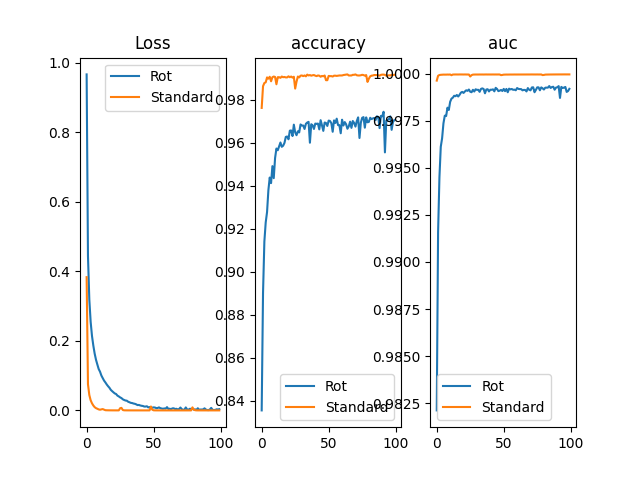

In [27]:

nepochs = 100
Esave = []
E1save = []
accuracysave = []
accuracy1save = []
aucsave = []
auc1save = []
fig,ax = plt.subplots(1,3)
net = net.to(device)
net1 = net1.to(device)
for e in range(nepochs):
    E_ = []
    E1_ = []
    count = 0
    for x,l in loader:
        x = x.to(device)
        l = l.to(device)
        optimizer.zero_grad()
        lhat = net(x)
        E = loss(lhat,l.squeeze())
        E.backward()
        optimizer.step()
        E_.append(E.item())
        
        optimizer1.zero_grad()
        lhat = net1(x)
        E = loss(lhat,l.squeeze())
        E.backward()
        optimizer1.step()
        E1_.append(E.item())
        
        
        if count > 10000000: 
            break # stop early for this example
        count += 1
    Esave.append(np.mean(E_))
    E1save.append(np.mean(E1_))
    ax[0].cla()
    ax[0].plot(Esave,label='Rot')
    ax[0].plot(E1save,label='Standard')
    ax[0].legend()
    ax[0].set_title('Loss')
    
    
    with torch.no_grad():
        net.train(False)
        net1.train(False)
        ltrue = []
        lhat = []
        lhat1 = []
        for x,l in loader_test:
            x = x.to(device)
            l = l.to(device)
            lhat.append(net(x).cpu())
            lhat1.append(net1(x).cpu())

            ltrue.append(l.cpu())
        net.train(True)
        net1.train(True)
        
    rotaccuracy = accuracy_score(torch.concatenate(ltrue),torch.argmax(torch.concatenate(lhat) ,-1) )
    standard_accuracy = accuracy_score(torch.concatenate(ltrue),torch.argmax(torch.concatenate(lhat1) ,-1) )
    accuracysave.append(rotaccuracy)
    accuracy1save.append(standard_accuracy)

    rotauc = roc_auc_score(torch.concatenate(ltrue).squeeze(),torch.softmax(torch.concatenate(lhat) , -1) , multi_class='ovr')
    standardauc = roc_auc_score(torch.concatenate(ltrue).squeeze(),torch.softmax(torch.concatenate(lhat1) , -1) , multi_class='ovr')
    aucsave.append(rotauc)
    auc1save.append(standardauc)
    
    ax[1].cla()
    ax[1].plot(accuracysave,label='Rot')
    ax[1].plot(accuracy1save,label='Standard')
    ax[1].legend()
    ax[1].set_title('accuracy')
    
    ax[2].cla()
    ax[2].plot(aucsave,label='Rot')
    ax[2].plot(auc1save,label='Standard')
    ax[2].legend()
    ax[2].set_title('auc')
    fig.canvas.draw()
    
    

In [36]:
accuracysave[-1]

0.9706

In [28]:
with torch.no_grad():
    nangles = 32
    angles = np.arange(nangles)/nangles*360
    accuracysave_ = []
    accuracy1save_ = []
    aucsave_ = []
    auc1save_ = []
    net.train(False)
    net1.train(False)
    
    for deg in angles:
        print(deg)
        ltrue = []
        lhat = []
        lhat1 = []
        for x,l in loader_test:        
            x = x.to(device)
            l = l.to(device)
            xrot = RandomRotation((deg,deg+0.0001))(x)
            lhat.append(net(xrot).cpu())
            lhat1.append(net1(xrot).cpu())
            ltrue.append(l.cpu())

        rotaccuracy = accuracy_score(torch.concatenate(ltrue),torch.argmax(torch.concatenate(lhat) ,-1) )
        standard_accuracy = accuracy_score(torch.concatenate(ltrue),torch.argmax(torch.concatenate(lhat1) ,-1) )
        accuracysave_.append(rotaccuracy)
        accuracy1save_.append(standard_accuracy)

        rotauc = roc_auc_score(torch.concatenate(ltrue).squeeze(),torch.softmax(torch.concatenate(lhat) , -1) , multi_class='ovr')
        standardauc = roc_auc_score(torch.concatenate(ltrue).squeeze(),torch.softmax(torch.concatenate(lhat1) , -1) , multi_class='ovr')
        aucsave_.append(rotauc)
        auc1save_.append(standardauc)


0.0
11.25
22.5
33.75
45.0
56.25
67.5
78.75
90.0
101.25
112.5
123.75
135.0
146.25
157.5
168.75
180.0
191.25
202.5
213.75
225.0
236.25
247.5
258.75
270.0
281.25
292.5
303.75
315.0
326.25
337.5
348.75


<IPython.core.display.Javascript object>


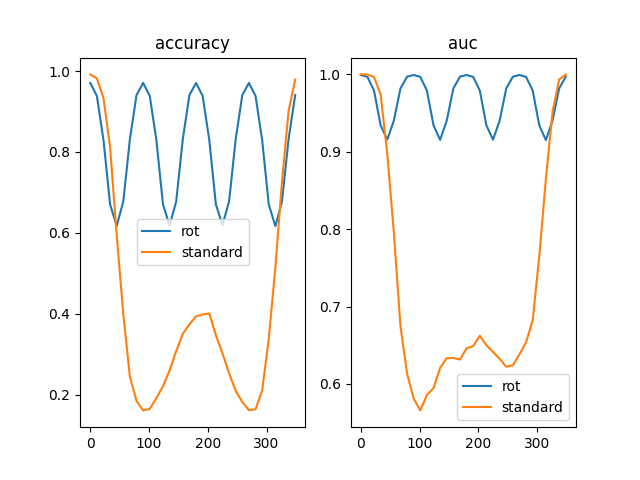

In [29]:
fig,ax = plt.subplots(1,2)
ax[0].plot(angles,accuracysave_,label='rot')
ax[0].plot(angles,accuracy1save_,label='standard')
ax[0].set_title('accuracy')
ax[0].legend()
ax[1].plot(angles,aucsave_,label='rot')
ax[1].plot(angles,auc1save_,label='standard')
ax[1].set_title('auc')
ax[1].legend()

In [30]:
# also reflections
with torch.no_grad():    
    angles = np.arange(nangles)/nangles*360
    accuracysave_ = []
    accuracy1save_ = []
    aucsave_ = []
    auc1save_ = []
    net.train(False)
    net1.train(False)
    
    for deg in angles:
        print(deg)
        ltrue = []
        lhat = []
        lhat1 = []
        for x,l in loader_test:  
            x = x.to(device)
            l = l.to(device)
            x = x.flip(dims=(-2,)) # flip columns
            xrot = RandomRotation((deg,deg+0.0001))(x)
            lhat.append(net(xrot).cpu())
            lhat1.append(net1(xrot).cpu())
            ltrue.append(l.cpu())

        rotaccuracy = accuracy_score(torch.concatenate(ltrue),torch.argmax(torch.concatenate(lhat) ,-1) )
        standard_accuracy = accuracy_score(torch.concatenate(ltrue),torch.argmax(torch.concatenate(lhat1) ,-1) )
        accuracysave_.append(rotaccuracy)
        accuracy1save_.append(standard_accuracy)

        rotauc = roc_auc_score(torch.concatenate(ltrue).squeeze(),torch.softmax(torch.concatenate(lhat) , -1) , multi_class='ovr')
        standardauc = roc_auc_score(torch.concatenate(ltrue).squeeze(),torch.softmax(torch.concatenate(lhat1) , -1) , multi_class='ovr')
        aucsave_.append(rotauc)
        auc1save_.append(standardauc)


0.0
11.25
22.5
33.75
45.0
56.25
67.5
78.75
90.0
101.25
112.5
123.75
135.0
146.25
157.5
168.75
180.0
191.25
202.5
213.75
225.0
236.25
247.5
258.75
270.0
281.25
292.5
303.75
315.0
326.25
337.5
348.75


<IPython.core.display.Javascript object>


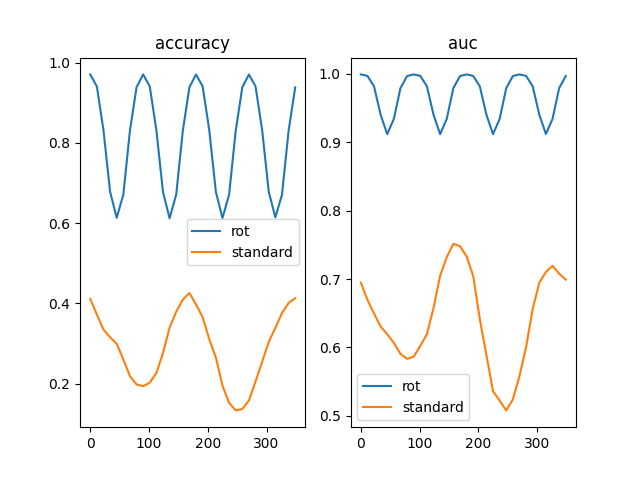

In [31]:
fig,ax = plt.subplots(1,2)
ax[0].plot(angles,accuracysave_,label='rot')
ax[0].plot(angles,accuracy1save_,label='standard')
ax[0].set_title('accuracy')
ax[0].legend()
ax[1].plot(angles,aucsave_,label='rot')
ax[1].plot(angles,auc1save_,label='standard')
ax[1].set_title('auc')
ax[1].legend()

In [32]:
# find the cases where the two networks give different results or are wrong

<IPython.core.display.Javascript object>


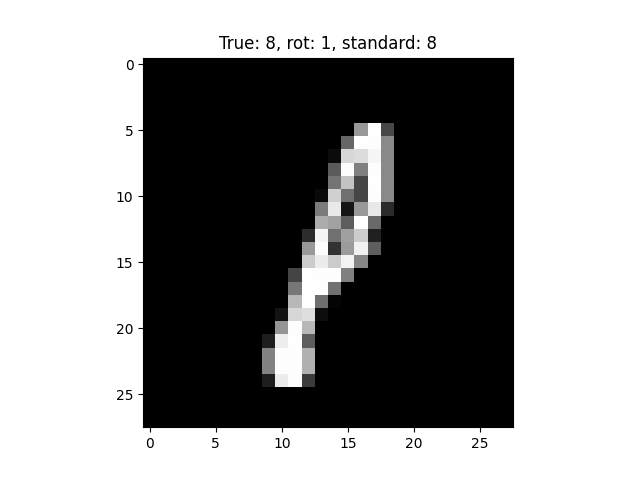

<IPython.core.display.Javascript object>


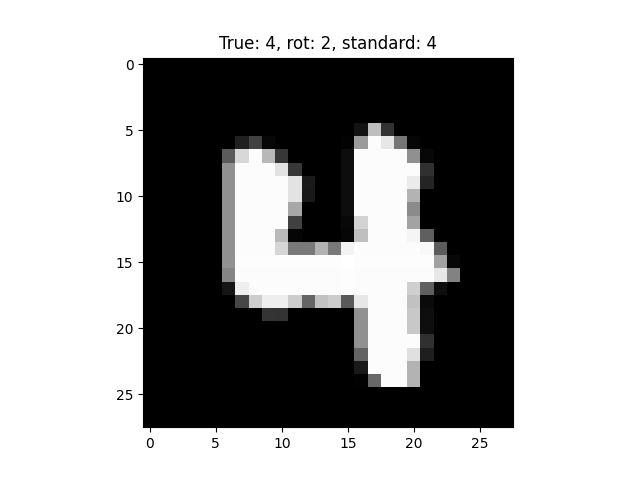

<IPython.core.display.Javascript object>


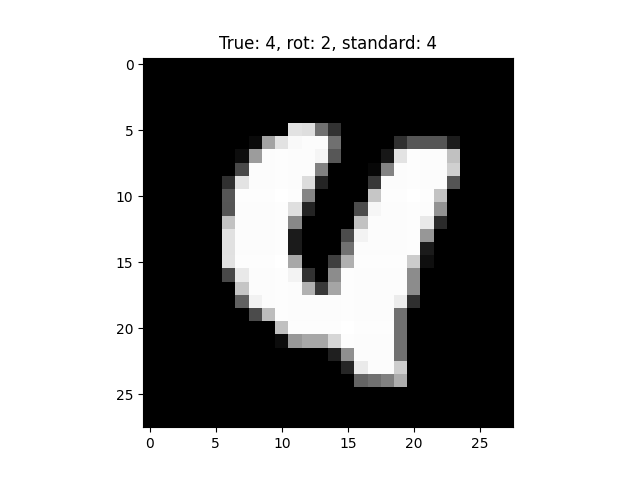

<IPython.core.display.Javascript object>


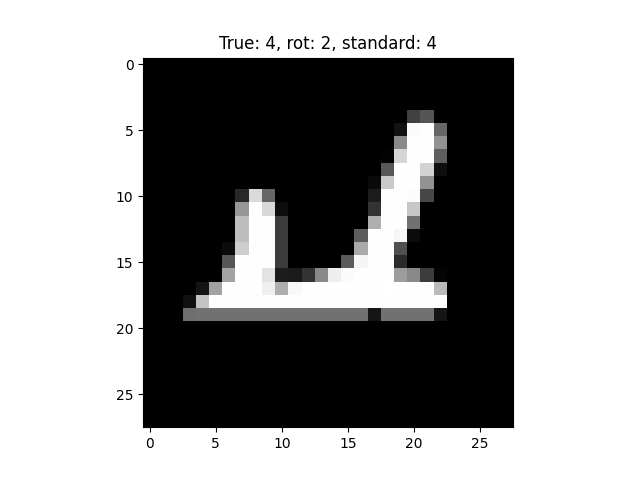

<IPython.core.display.Javascript object>


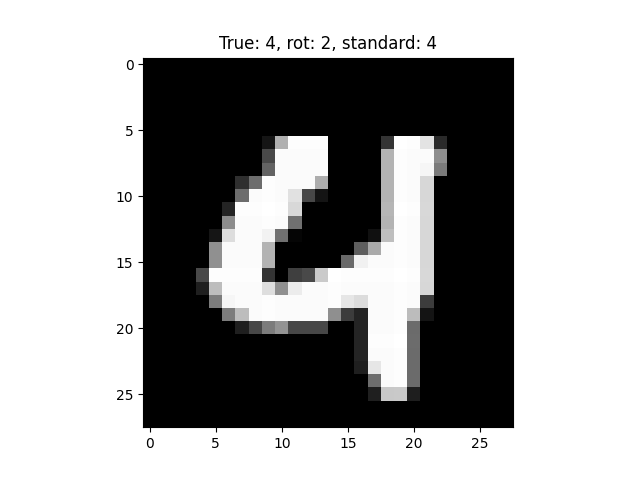

<IPython.core.display.Javascript object>


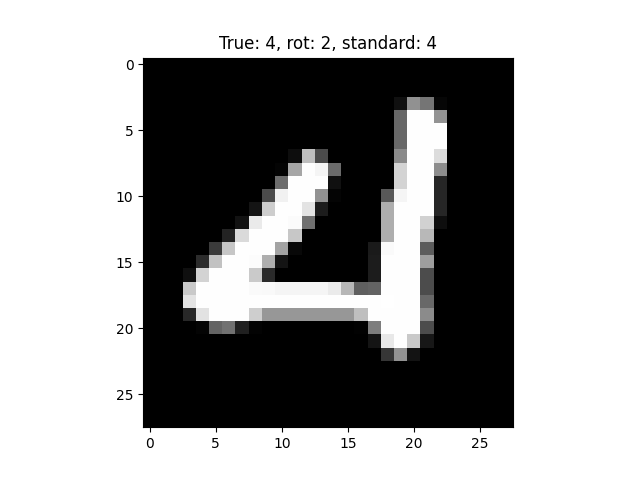

<IPython.core.display.Javascript object>


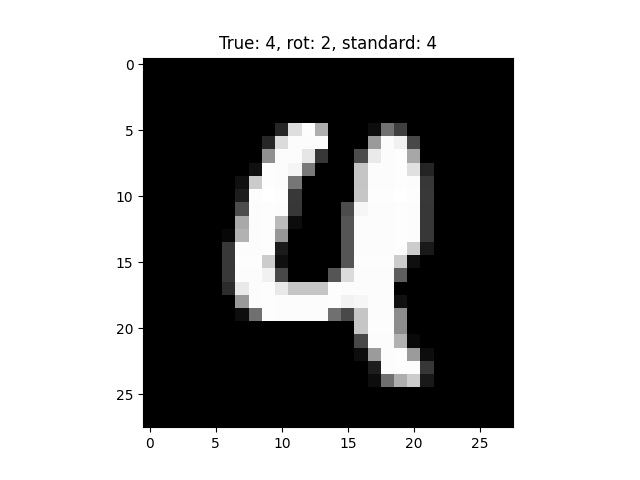

<IPython.core.display.Javascript object>


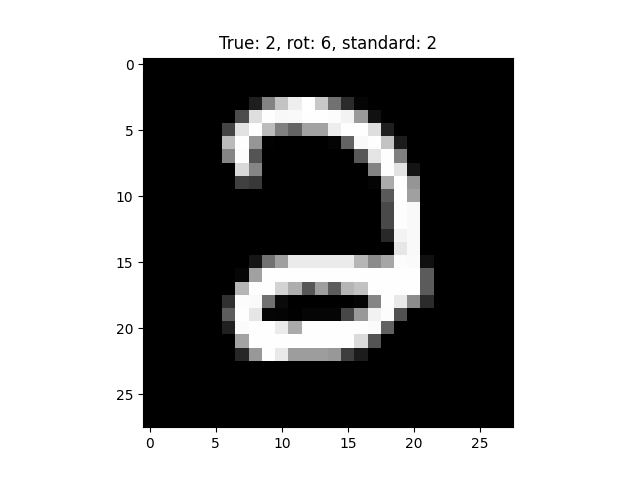

<IPython.core.display.Javascript object>


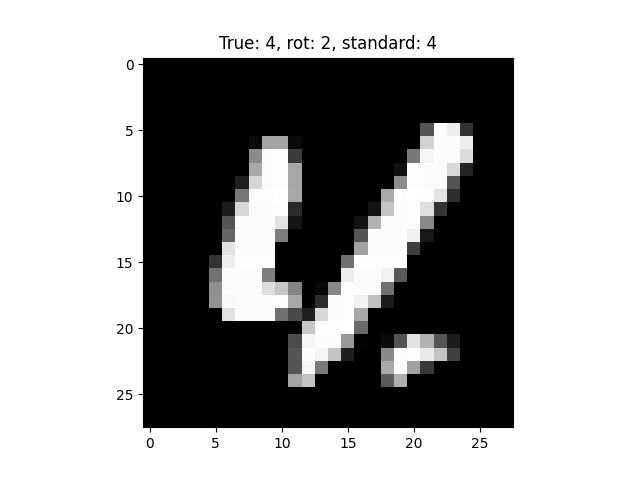

<IPython.core.display.Javascript object>


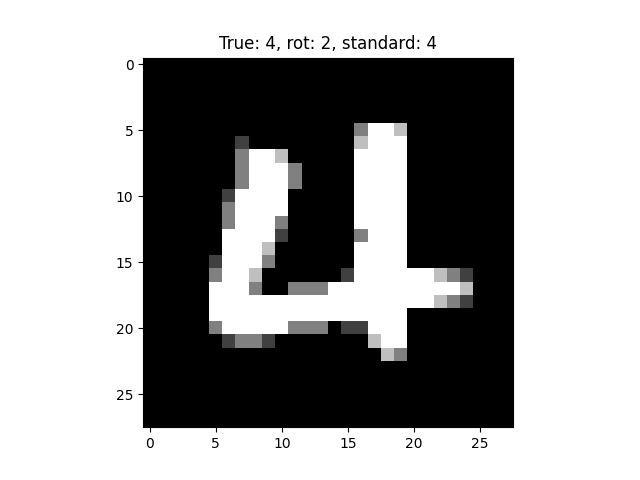

<IPython.core.display.Javascript object>


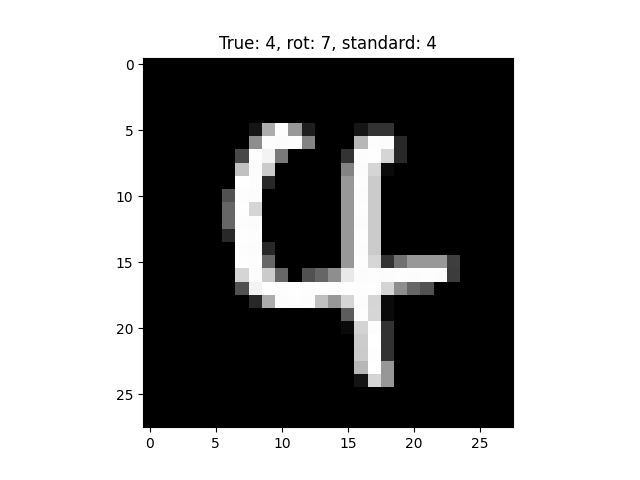

<IPython.core.display.Javascript object>


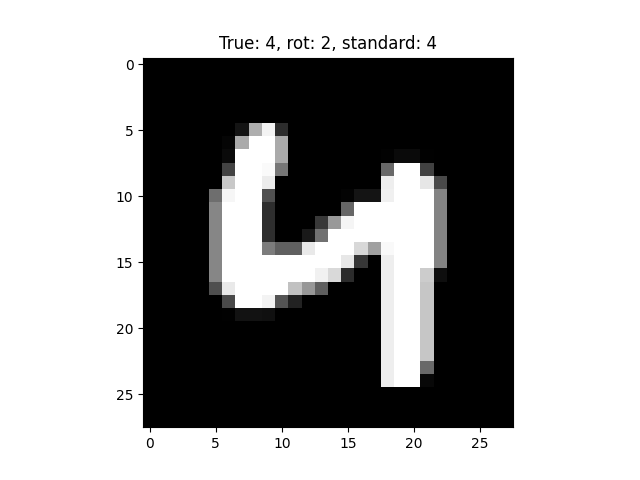

<IPython.core.display.Javascript object>


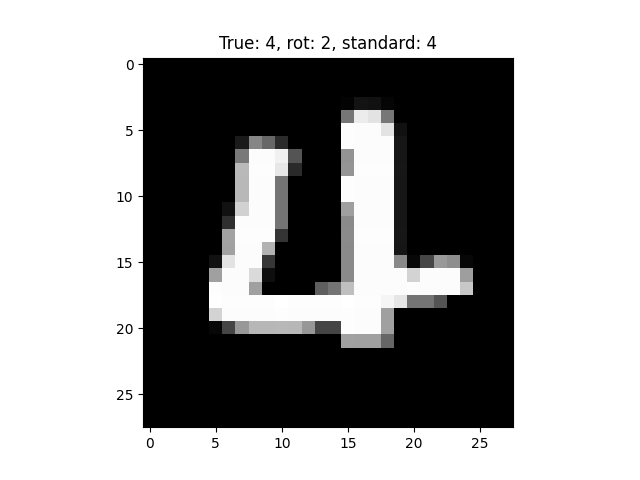

<IPython.core.display.Javascript object>


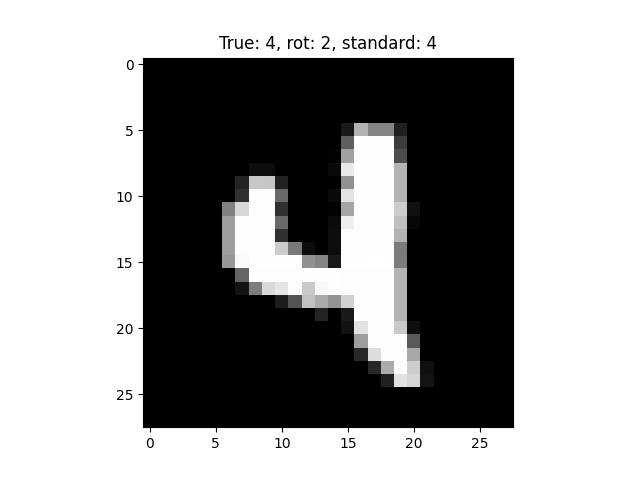

<IPython.core.display.Javascript object>


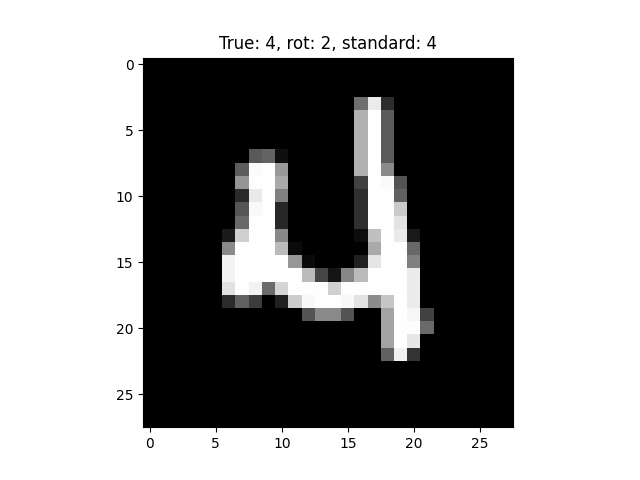

<IPython.core.display.Javascript object>


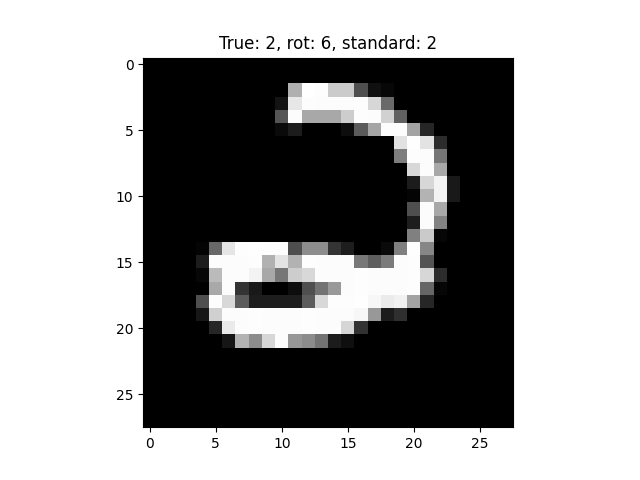

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


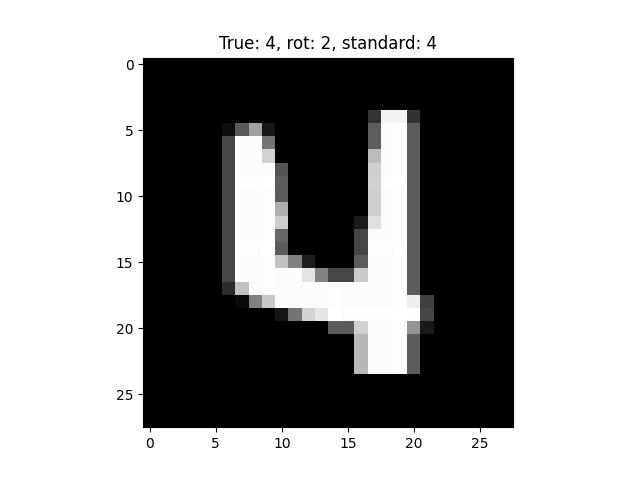

<IPython.core.display.Javascript object>


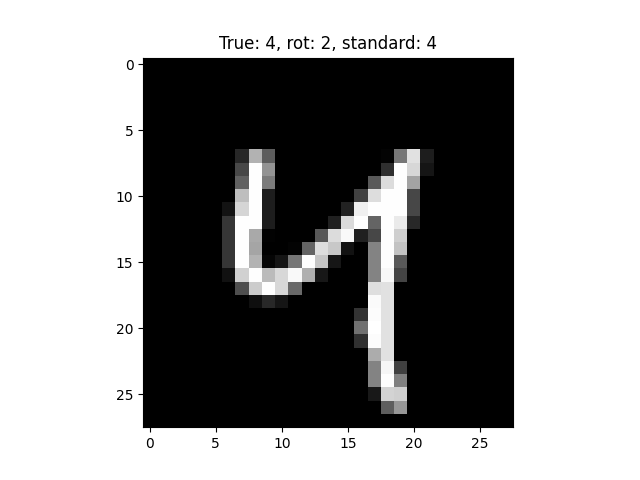

<IPython.core.display.Javascript object>


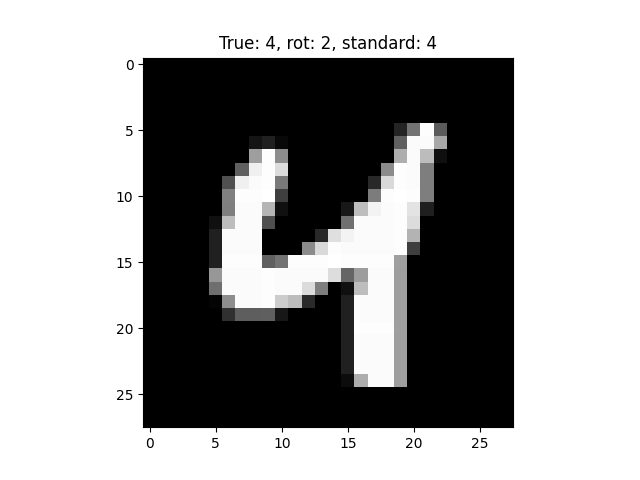

<IPython.core.display.Javascript object>


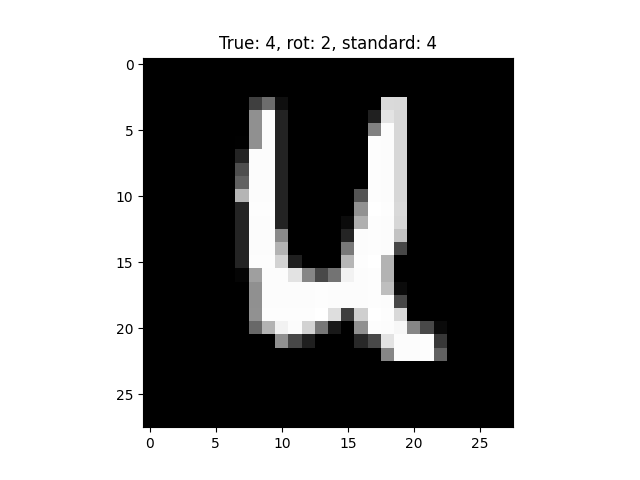

<IPython.core.display.Javascript object>


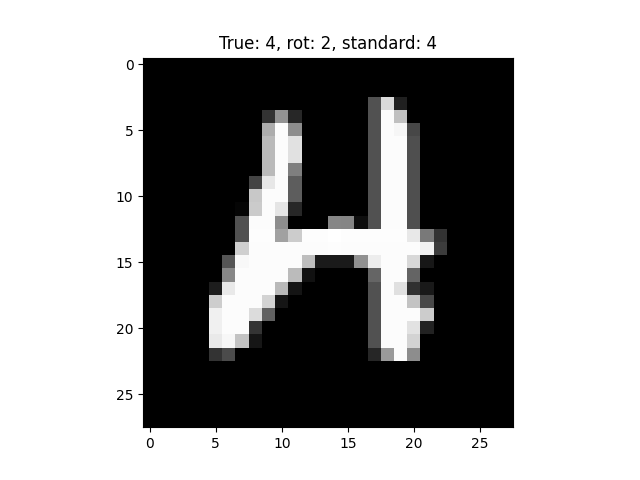

In [34]:
count = 0
with torch.no_grad():
    net.train(False)
    net1.train(False)
    for x,l in loader:
        x = x.to(device)
        l = l.to(device)
        lhat = net(x)
        classhat = torch.argmax(lhat,-1)
        l1hat = net1(x)
        class1hat = torch.argmax(l1hat,-1)
        
        # if any are wrong, let's see
        if torch.any( classhat !=l ) or torch.any( class1hat != l ):
            for xi,ci,c1i,li in zip(x,classhat,class1hat,l):
                if ci != li or c1i != li:
                    fig,ax = plt.subplots()
                    ax.imshow(xi[0].cpu(),cmap='gray')
                    ax.set_title(f'True: {li}, rot: {ci}, standard: {c1i}')
                    count += 1
                    if count > 20: break
        if count > 20: break
        
                    
        
        
        

<IPython.core.display.Javascript object>


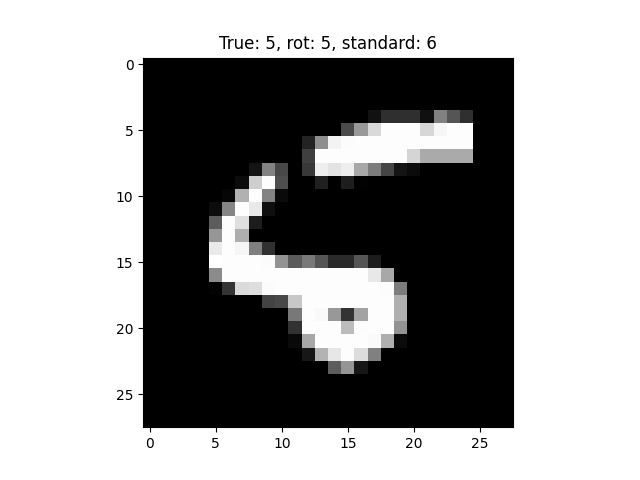

<IPython.core.display.Javascript object>


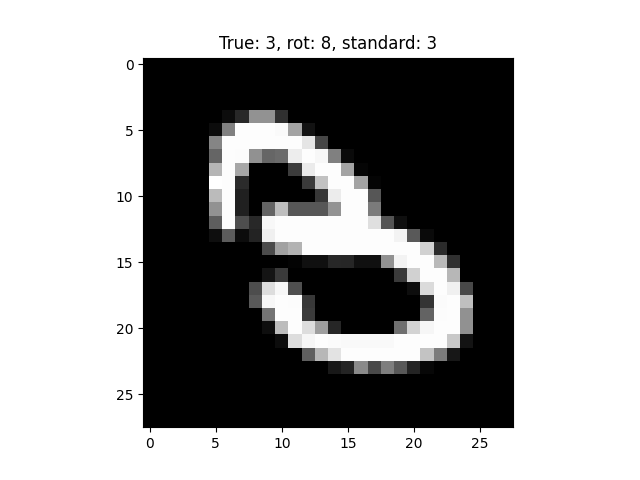

<IPython.core.display.Javascript object>


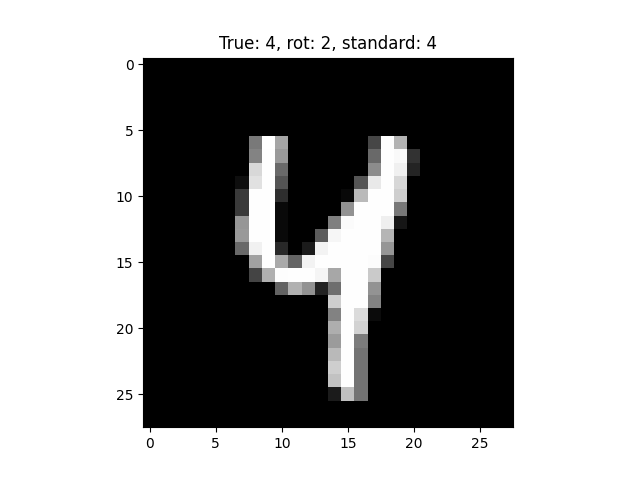

<IPython.core.display.Javascript object>


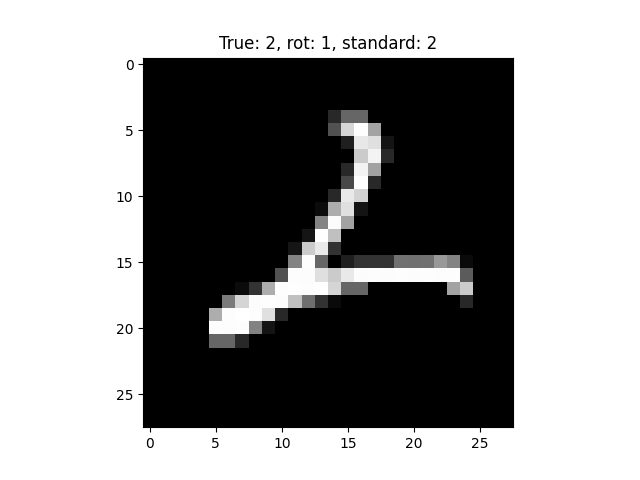

<IPython.core.display.Javascript object>


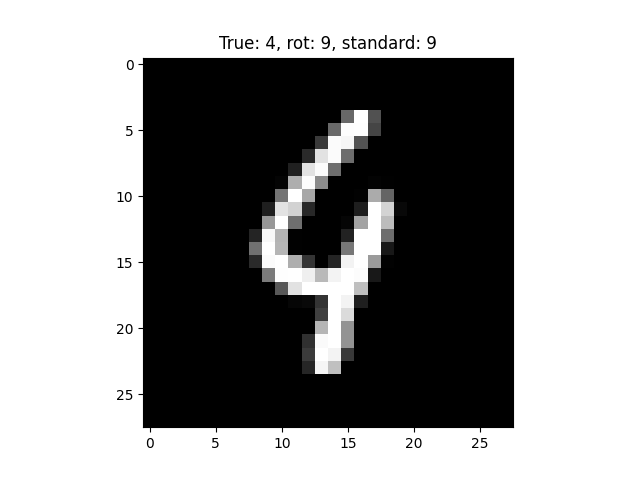

<IPython.core.display.Javascript object>


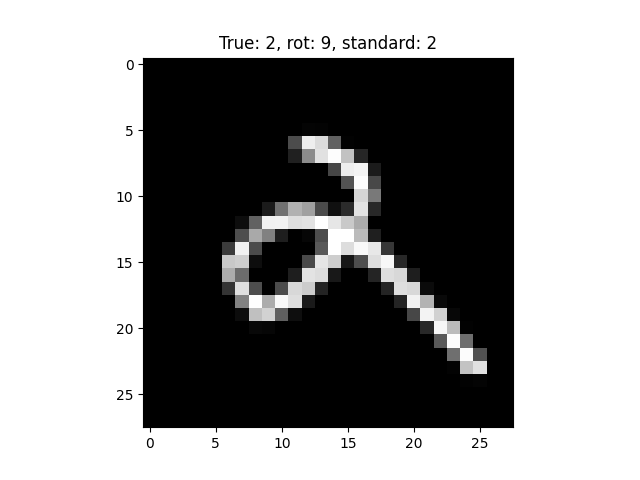

<IPython.core.display.Javascript object>


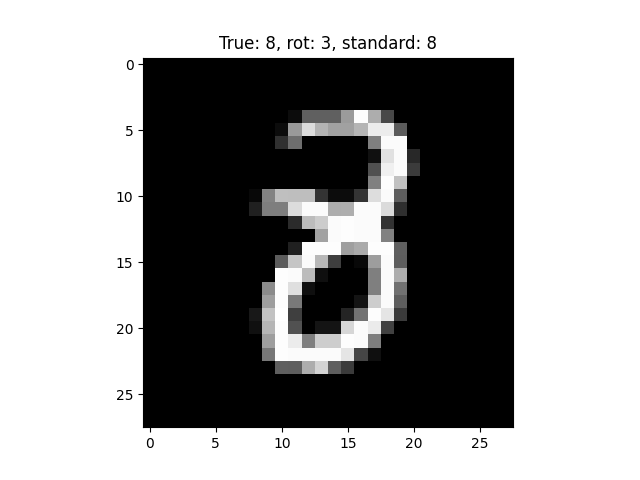

<IPython.core.display.Javascript object>


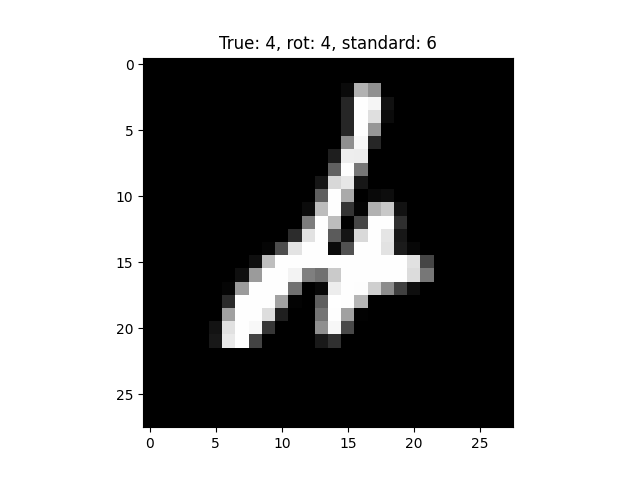

<IPython.core.display.Javascript object>


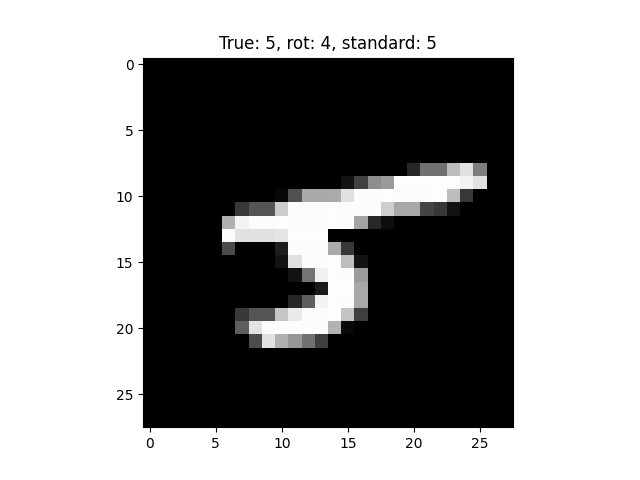

<IPython.core.display.Javascript object>


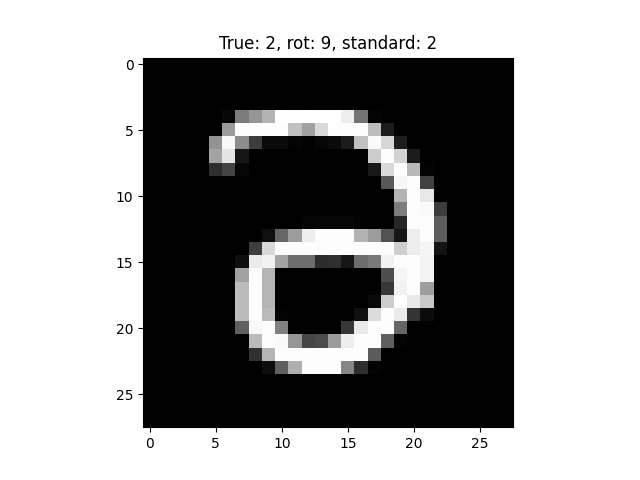

<IPython.core.display.Javascript object>


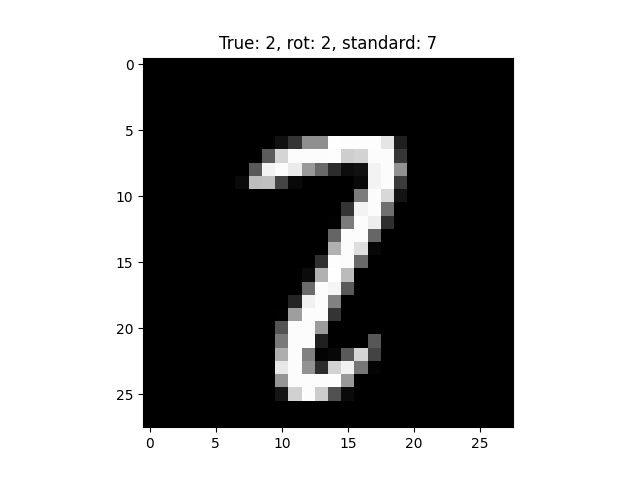

<IPython.core.display.Javascript object>


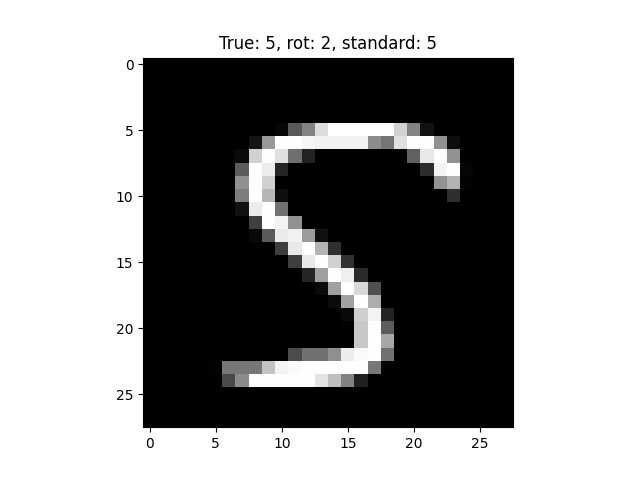

<IPython.core.display.Javascript object>


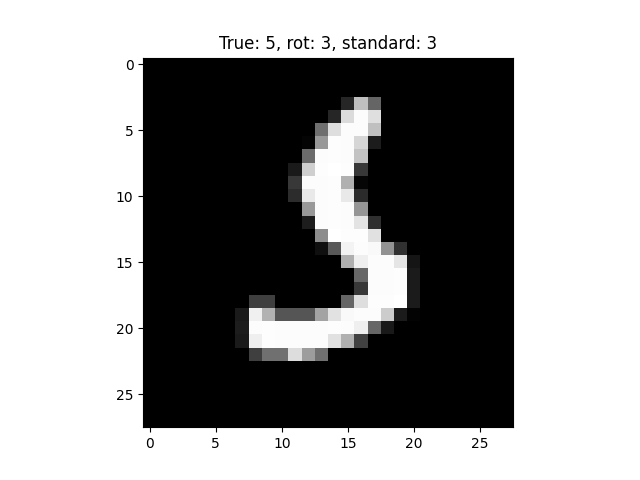

<IPython.core.display.Javascript object>


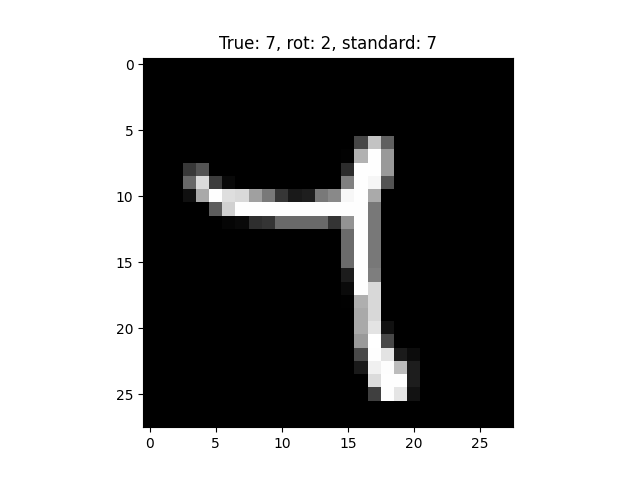

<IPython.core.display.Javascript object>


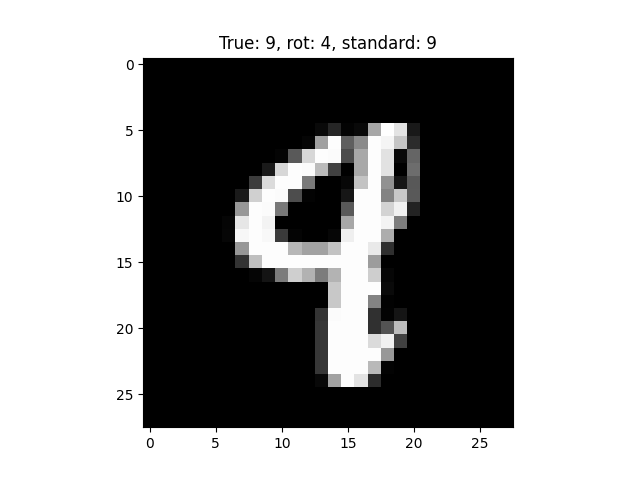

<IPython.core.display.Javascript object>


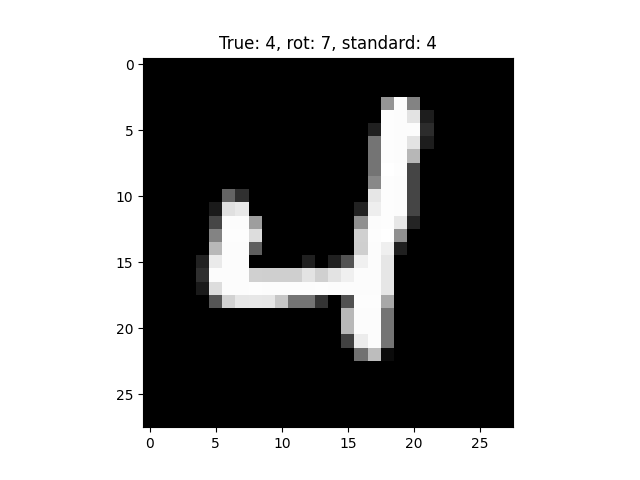

<IPython.core.display.Javascript object>


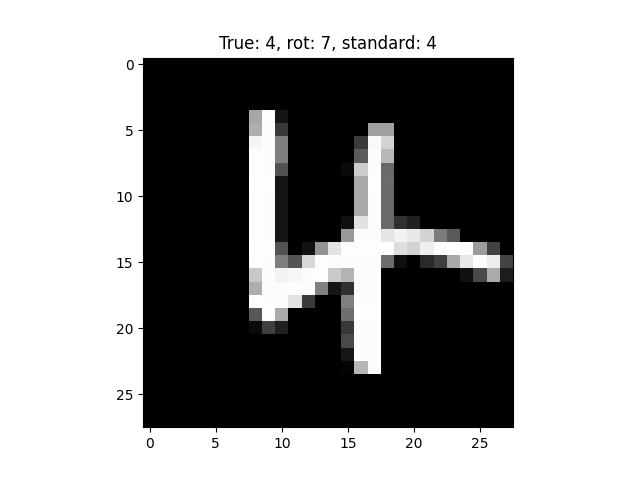

<IPython.core.display.Javascript object>


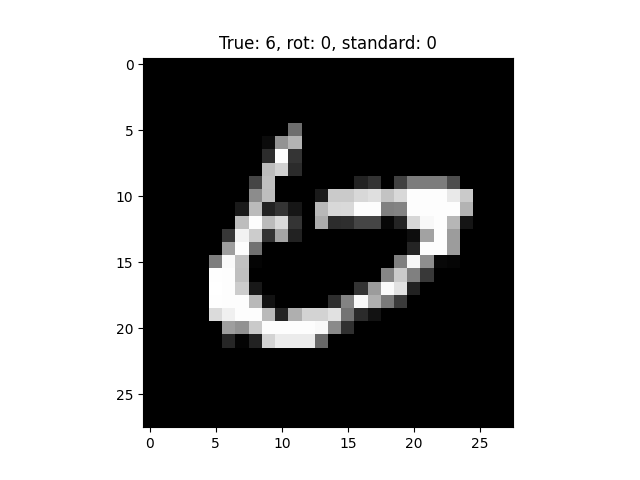

<IPython.core.display.Javascript object>


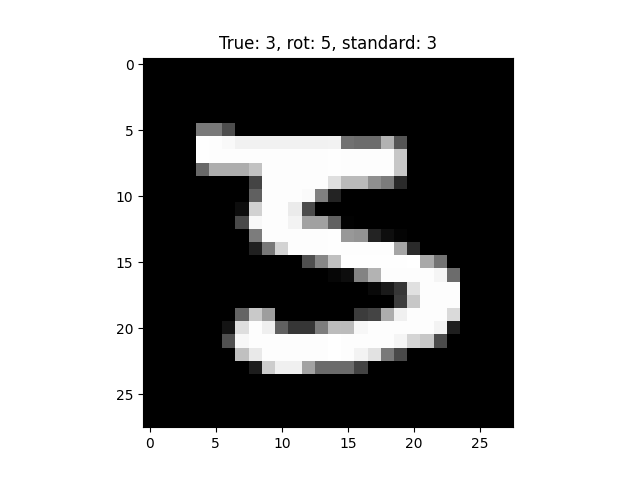

<IPython.core.display.Javascript object>


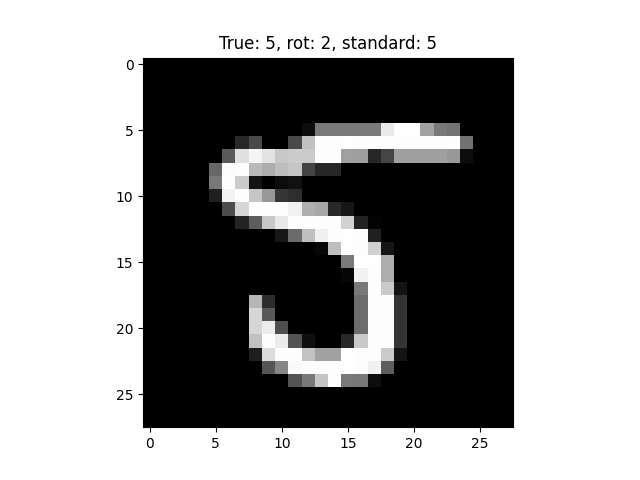

<IPython.core.display.Javascript object>


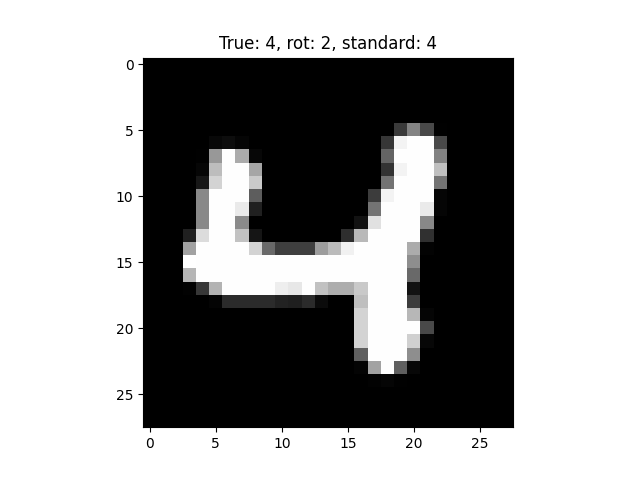

In [35]:
count = 0
with torch.no_grad():
    net.train(False)
    net1.train(False)
    for x,l in loader_test:
        x = x.to(device)
        l = l.to(device)
        lhat = net(x)
        classhat = torch.argmax(lhat,-1)
        l1hat = net1(x)
        class1hat = torch.argmax(l1hat,-1)
        
        # if any are wrong, let's see
        if torch.any( classhat !=l ) or torch.any( class1hat != l ):
            for xi,ci,c1i,li in zip(x,classhat,class1hat,l):
                if ci != li or c1i != li:
                    fig,ax = plt.subplots()
                    ax.imshow(xi[0].cpu(),cmap='gray')
                    ax.set_title(f'True: {li}, rot: {ci}, standard: {c1i}')
                    count += 1
                    if count > 20: break
        if count > 20: break
        
                    
        
        
        